# Natural Language Processing with DistilBERT for Disaster Tweet Classification

## Project Overview
In this project, we'll build a machine learning model that can identify whether a tweet is about a real disaster or not. This is an important application of NLP that could help emergency responders identify real emergencies from social media data.

### Dataset
- 10,000 hand-classified tweets
- Binary classification task (disaster vs. non-disaster)
- Features include tweet text, keywords, and location information

### Technical Approach
We're using **DistilBERT**, a lightweight and efficient transformer model:
- 40% smaller than BERT
- 60% faster processing
- Maintains 97% of BERT's performance
- Perfect for real-world applications where efficiency matters

### What is BERT?
**BERT** (Bidirectional Encoder Representations from Transformers) revolutionized NLP by:
- Processing text bidirectionally (understanding context from both directions)
- Pre-training on massive text datasets
- Providing rich contextual word embeddings
- Supporting fine-tuning for specific tasks

![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)

### Notebook Contents
1. Data Loading & Exploration
2. Text Preprocessing
3. Model Setup (DistilBERT)
4. Training Pipeline
5. Evaluation & Results
6. Prediction Generation

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import re
import string

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
)

from collections import Counter
from wordcloud import WordCloud
from datasets import Dataset

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

# Data Loading and Initial Exploration

Our dataset contains tweets that have been manually classified. Let's understand its structure:

### Features
1. **id**: Unique identifier for each tweet
2. **keyword**: A keyword extracted from the tweet (may be empty)
3. **location**: The location the tweet was sent from (may be empty)
4. **text**: The actual content of the tweet
5. **target**: Our label
   - 1 = Real disaster tweet
   - 0 = Not a real disaster tweet

### Why these features matter:
- **keywords**: Often indicate the topic/emergency type
- **location**: Could show geographical patterns in disaster reporting
- **text**: Contains the main information we'll use for classification

We'll load both training and test sets to begin our analysis.

In [5]:
df_train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv("Data/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [6]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.161697
std        33.854073
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.241189
std        34.052153
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

# Meta Features Analysis

Let's extract meta features that could help identify disaster tweets:
- word_count: number of words in text
- unique_word_count: number of unique words in text
- stop_word_count: number of stop words in text
- url_count: number of urls in text
- mean_word_length: average character count in words
- char_count: number of characters in text
- punctuation_count: number of punctuations in text
- hashtag_count: number of hashtags (#) in text
- mention_count: number of mentions (@) in text

In [ ]:
from nltk.corpus import stopwords
import nltk

# Download required NLTK data
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

def extract_meta_features(df):
    """Extract meta features from the text column of a dataframe."""
    
    # Get stop words
    stop_words = set(stopwords.words('english'))
    
    # Create meta features
    meta_features = pd.DataFrame()
    
    # Basic word counts
    meta_features['word_count'] = df['text'].str.split().str.len()
    
    # Unique word counts
    meta_features['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).lower().split())))
    
    # Stop word count
    meta_features['stop_word_count'] = df['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stop_words]))
    
    # URL count
    meta_features['url_count'] = df['text'].str.count(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    
    # Mean word length
    meta_features['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
    
    # Character count
    meta_features['char_count'] = df['text'].str.len()
    
    # Punctuation count
    meta_features['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
    # Hashtag count
    meta_features['hashtag_count'] = df['text'].str.count('#')
    
    # Mention count
    meta_features['mention_count'] = df['text'].str.count('@')
    
    return meta_features

# Extract meta features for both train and test sets
print("Extracting meta features...")
train_meta = extract_meta_features(df_train)
test_meta = extract_meta_features(df_test)

# Add meta features to the original dataframes
for column in train_meta.columns:
    df_train[column] = train_meta[column]
    df_test[column] = test_meta[column]

# Display summary statistics of meta features
print("\nMeta Features Summary (Training Set):")
print(train_meta.describe())

# Visualize meta feature distributions
plt.figure(figsize=(15, 10))

for i, column in enumerate(train_meta.columns, 1):
    plt.subplot(3, 3, i)
    
    if df_train['target'].nunique() > 1:  # Only for training set
        for target in [0, 1]:
            data = df_train[df_train['target'] == target][column]
            plt.hist(data, bins=30, alpha=0.5, label=f"{'Disaster' if target == 1 else 'Non-Disaster'}")
        plt.legend()
    
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Exploratory Data Analysis

Function to clean text

In [9]:
def clean_text(text):
    # Handle empty/missing text
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove URLs (more comprehensive pattern)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Extract hashtag content but remove the # symbol
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove numbers but keep important ones like "911"
    text = re.sub(r'\b\d+\b(?<!911)', '', text)
    
    # Remove RT (retweet) indicators
    text = re.sub(r'\brt\b', '', text)
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove punctuation except ! and ? as they might indicate urgency
    text = re.sub(r'[^\w\s!?]', '', text)
    
    # Remove repeated characters (e.g., 'helpppp' → 'help')
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    
    # Strip extra whitespace
    text = text.strip()
    
    return text

Get all words from tweets

In [11]:
# Disaster tweets
disaster_tweets = df_train[df_train['target'] == 1]['text'].apply(clean_text)
disaster_words = ' '.join(disaster_tweets).split()

# Non-disaster tweets
non_disaster_tweets = df_train[df_train['target'] == 0]['text'].apply(clean_text)
non_disaster_words = ' '.join(non_disaster_tweets).split()

Create word clouds

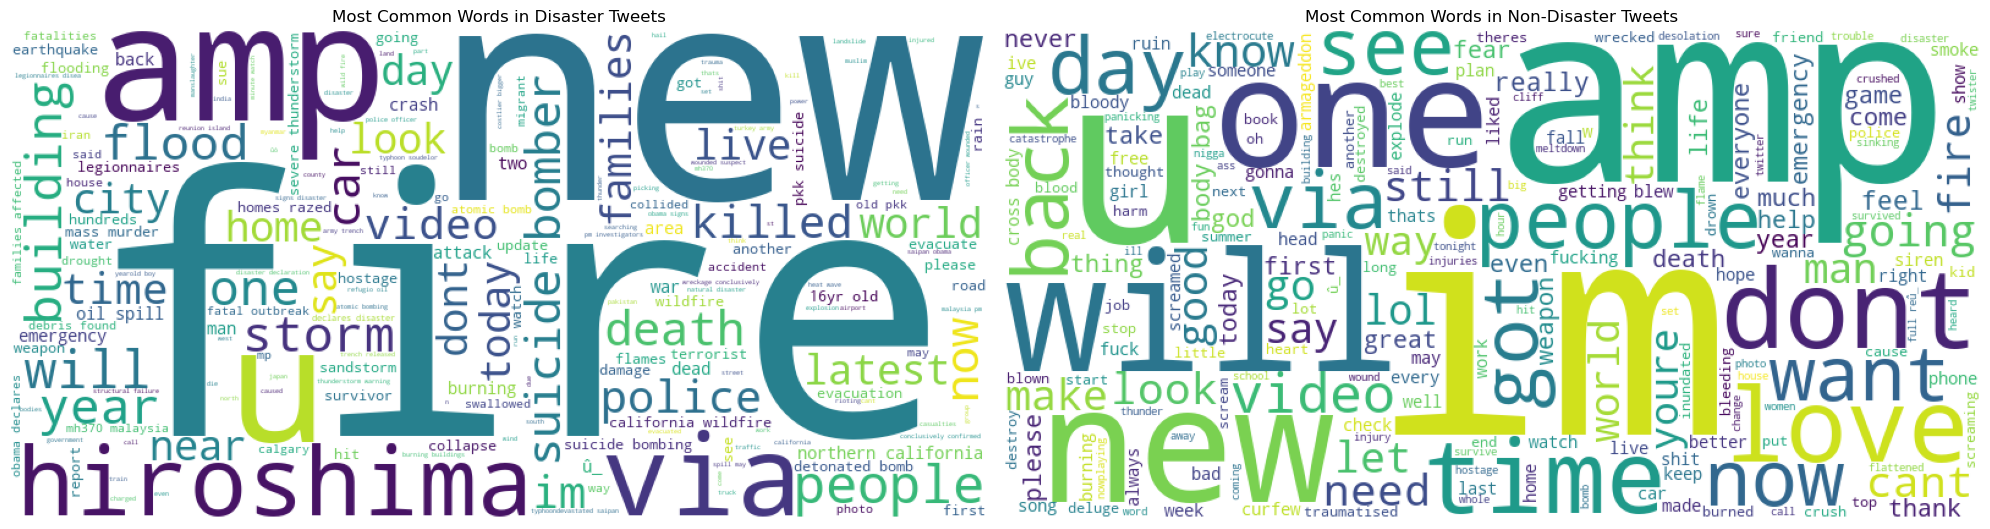

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Disaster tweets word cloud
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(' '.join(disaster_words))
ax1.imshow(wordcloud_disaster)
ax1.axis('off')
ax1.set_title('Most Common Words in Disaster Tweets')

# Non-disaster tweets word cloud
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_disaster_words))
ax2.imshow(wordcloud_non_disaster)
ax2.axis('off')
ax2.set_title('Most Common Words in Non-Disaster Tweets')

plt.tight_layout()
plt.show()

Show the most common words

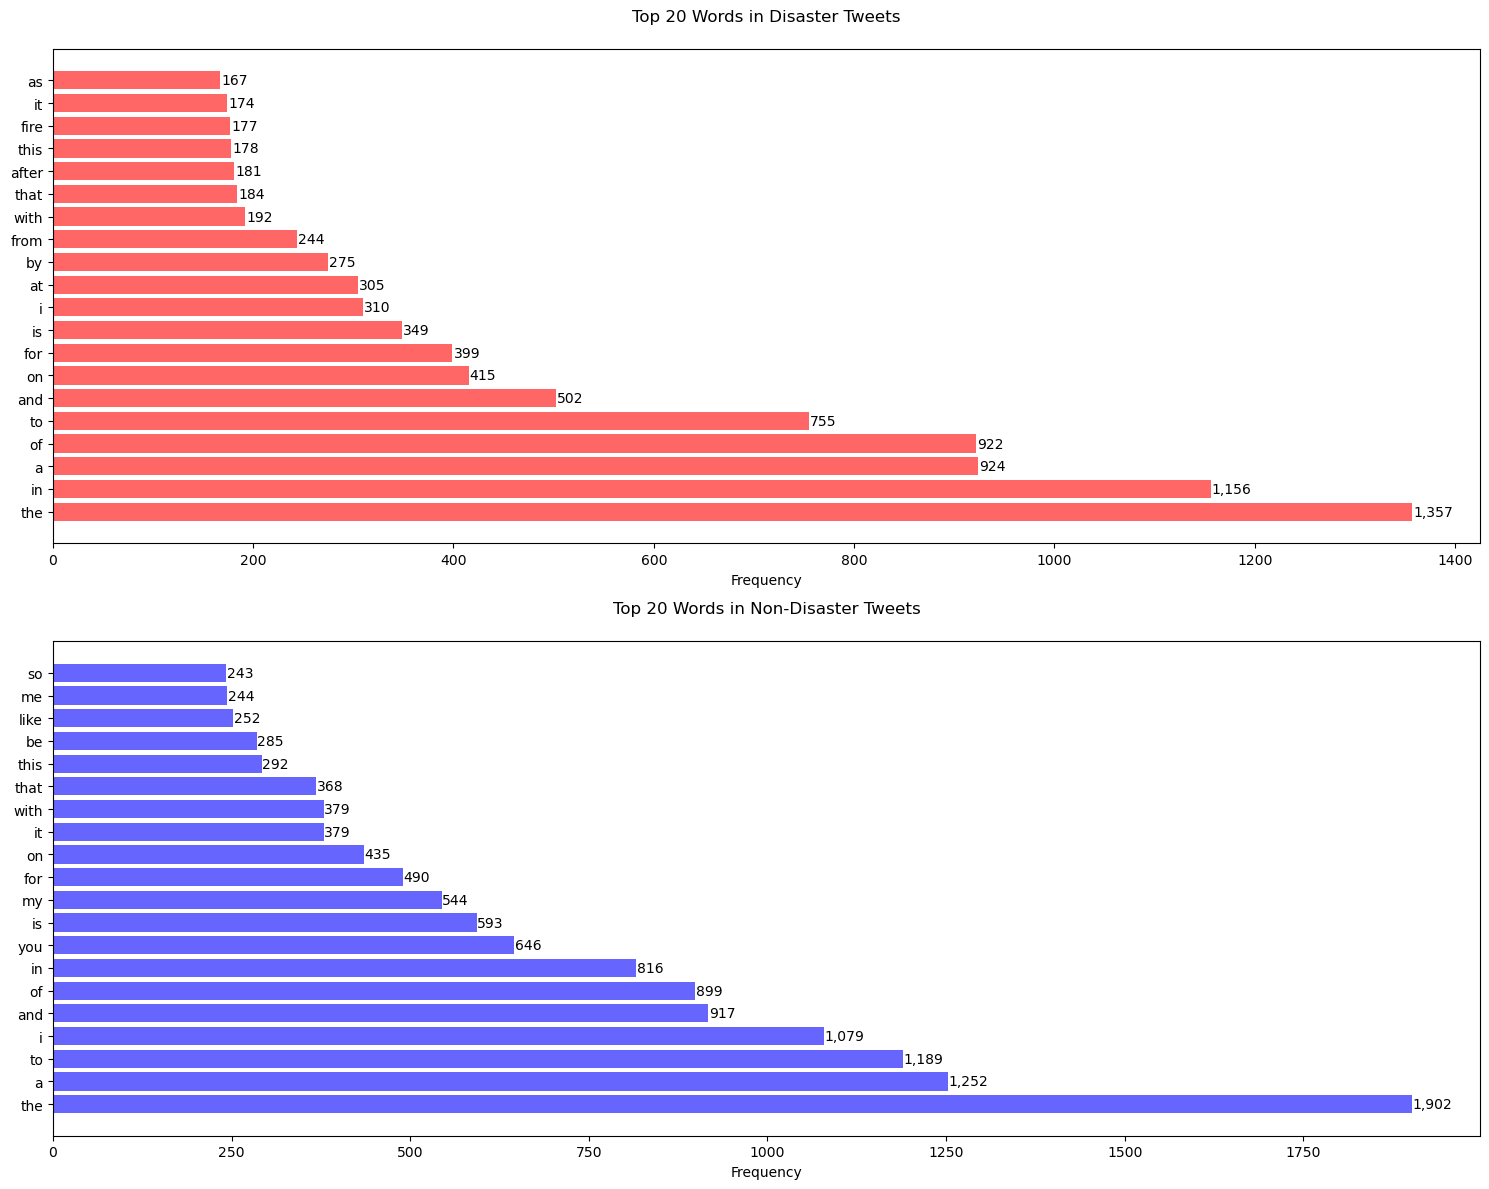


Top 20 words in Disaster Tweets:
the: 1357
in: 1156
a: 924
of: 922
to: 755
and: 502
on: 415
for: 399
is: 349
i: 310
at: 305
by: 275
from: 244
with: 192
that: 184
after: 181
this: 178
fire: 177
it: 174
as: 167

Top 20 words in Non-Disaster Tweets:
the: 1902
a: 1252
to: 1189
i: 1079
and: 917
of: 899
in: 816
you: 646
is: 593
my: 544
for: 490
on: 435
it: 379
with: 379
that: 368
this: 292
be: 285
like: 252
me: 244
so: 243


In [15]:
# Get the top 20 words and their counts
disaster_top20 = Counter(disaster_words).most_common(20)
non_disaster_top20 = Counter(non_disaster_words).most_common(20)

# Convert to lists for plotting
disaster_words_list, disaster_counts = zip(*disaster_top20)
non_disaster_words_list, non_disaster_counts = zip(*non_disaster_top20)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot disaster words
bars1 = ax1.barh(range(len(disaster_words_list)), disaster_counts, color='red', alpha=0.6)
ax1.set_yticks(range(len(disaster_words_list)))
ax1.set_yticklabels(disaster_words_list)
ax1.set_title('Top 20 Words in Disaster Tweets', pad=20)
ax1.set_xlabel('Frequency')

# Add count labels on the bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{int(width):,}',
             ha='left', va='center')

# Plot non-disaster words
bars2 = ax2.barh(range(len(non_disaster_words_list)), non_disaster_counts, color='blue', alpha=0.6)
ax2.set_yticks(range(len(non_disaster_words_list)))
ax2.set_yticklabels(non_disaster_words_list)
ax2.set_title('Top 20 Words in Non-Disaster Tweets', pad=20)
ax2.set_xlabel('Frequency')

# Add count labels on the bars
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{int(width):,}',
             ha='left', va='center')

plt.tight_layout()
plt.show()

# Print the actual counts for reference
print("\nTop 20 words in Disaster Tweets:")
for word, count in disaster_top20:
    print(f"{word}: {count}")

print("\nTop 20 words in Non-Disaster Tweets:")
for word, count in non_disaster_top20:
    print(f"{word}: {count}")

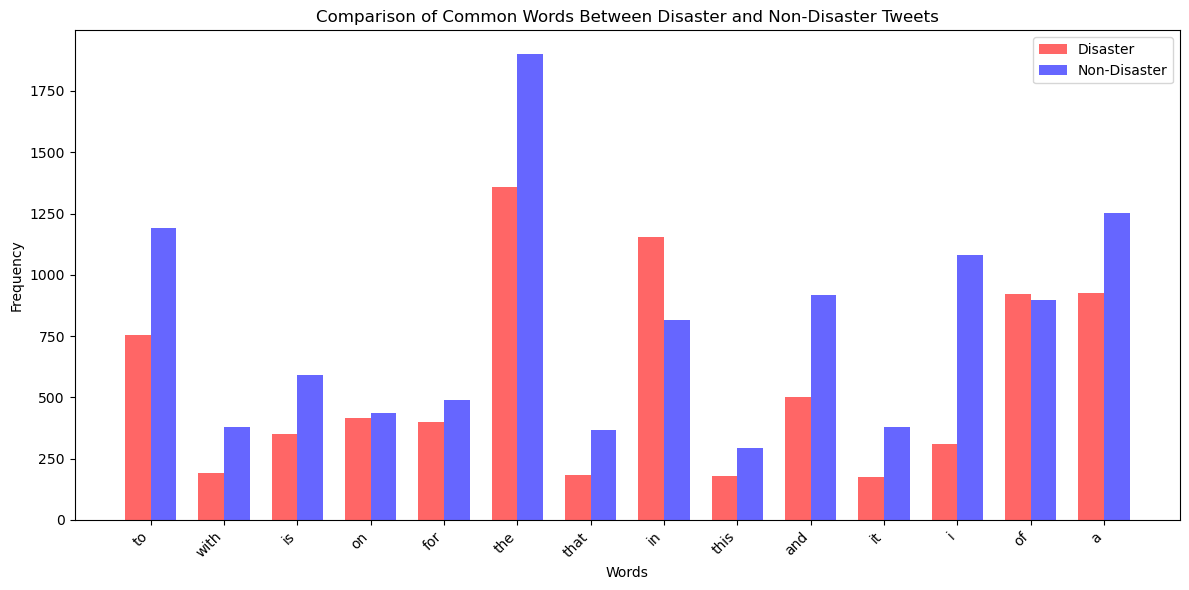


Frequency comparison of common words:
to: Disaster=755, Non-Disaster=1189
with: Disaster=192, Non-Disaster=379
is: Disaster=349, Non-Disaster=593
on: Disaster=415, Non-Disaster=435
for: Disaster=399, Non-Disaster=490
the: Disaster=1357, Non-Disaster=1902
that: Disaster=184, Non-Disaster=368
in: Disaster=1156, Non-Disaster=816
this: Disaster=178, Non-Disaster=292
and: Disaster=502, Non-Disaster=917
it: Disaster=174, Non-Disaster=379
i: Disaster=310, Non-Disaster=1079
of: Disaster=922, Non-Disaster=899
a: Disaster=924, Non-Disaster=1252


In [16]:
# Create a comparison plot for words that appear in both sets
disaster_dict = dict(disaster_top20)
non_disaster_dict = dict(non_disaster_top20)

# Find common words
common_words = set(disaster_dict.keys()) & set(non_disaster_dict.keys())

if common_words:
    # Create lists for plotting
    common_words = list(common_words)
    disaster_freq = [disaster_dict[word] for word in common_words]
    non_disaster_freq = [non_disaster_dict[word] for word in common_words]

    # Create comparison plot
    plt.figure(figsize=(12, 6))
    x = range(len(common_words))
    width = 0.35

    plt.bar([i - width/2 for i in x], disaster_freq, width, label='Disaster', color='red', alpha=0.6)
    plt.bar([i + width/2 for i in x], non_disaster_freq, width, label='Non-Disaster', color='blue', alpha=0.6)

    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Comparison of Common Words Between Disaster and Non-Disaster Tweets')
    plt.xticks(x, common_words, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print comparison
    print("\nFrequency comparison of common words:")
    for word in common_words:
        print(f"{word}: Disaster={disaster_dict[word]}, Non-Disaster={non_disaster_dict[word]}")

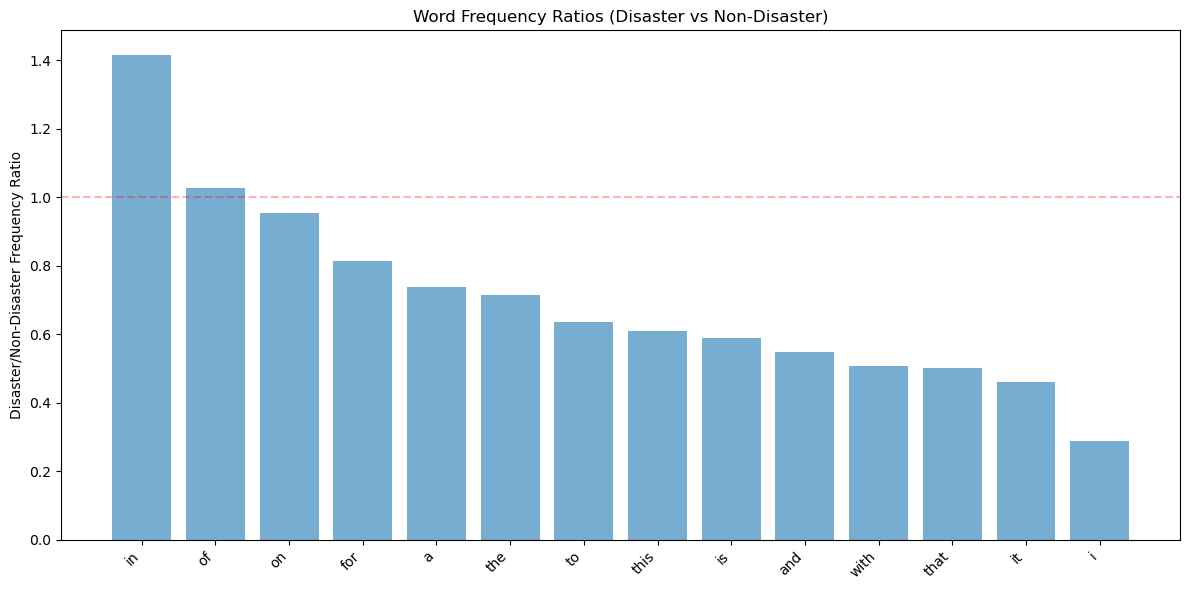


Word frequency ratios (Disaster/Non-Disaster):
in: 1.42
of: 1.03
on: 0.95
for: 0.81
a: 0.74
the: 0.71
to: 0.63
this: 0.61
is: 0.59
and: 0.55
with: 0.51
that: 0.50
it: 0.46
i: 0.29


In [17]:
# Calculate and visualize word frequency ratios
if common_words:
    ratios = [(word, disaster_dict[word] / non_disaster_dict[word]) for word in common_words]
    ratios.sort(key=lambda x: x[1], reverse=True)

    # Plot ratios
    plt.figure(figsize=(12, 6))
    words, ratio_values = zip(*ratios)
    
    plt.bar(range(len(words)), ratio_values, alpha=0.6)
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    plt.ylabel('Disaster/Non-Disaster Frequency Ratio')
    plt.title('Word Frequency Ratios (Disaster vs Non-Disaster)')
    plt.tight_layout()
    plt.show()

    print("\nWord frequency ratios (Disaster/Non-Disaster):")
    for word, ratio in ratios:
        print(f"{word}: {ratio:.2f}")

Feature Analysis

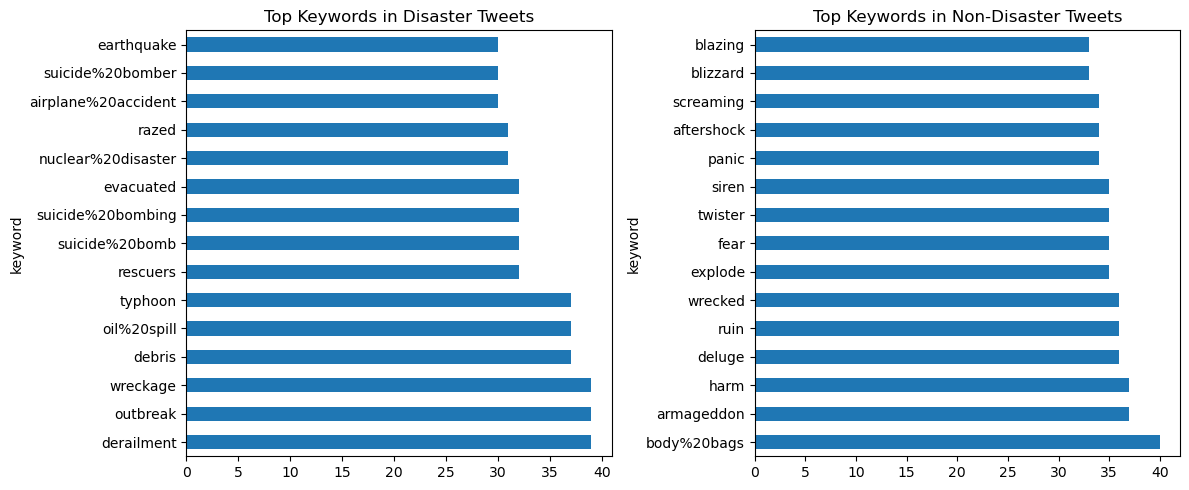


Location Statistics:
Training set tweets with location: 66.73%
Test set tweets with location: 66.14%

Top 10 Locations in Training Set:
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64


In [ ]:
# Keyword analysis
plt.figure(figsize=(12, 5))

# Top keywords in disaster tweets
disaster_keywords = df_train[df_train['target'] == 1]['keyword'].value_counts().head(15)
plt.subplot(1, 2, 1)
disaster_keywords.plot(kind='barh')
plt.title('Top Keywords in Disaster Tweets')

# Top keywords in non-disaster tweets
non_disaster_keywords = df_train[df_train['target'] == 0]['keyword'].value_counts().head(15)
plt.subplot(1, 2, 2)
non_disaster_keywords.plot(kind='barh')
plt.title('Top Keywords in Non-Disaster Tweets')

plt.tight_layout()
plt.show()

In [19]:
# Location analysis
print("\nLocation Statistics:")
print(f"Training set tweets with location: {(df_train['location'].notna().sum() / len(df_train)) * 100:.2f}%")
print(f"Test set tweets with location: {(df_test['location'].notna().sum() / len(df_test)) * 100:.2f}%")

# Top locations
print("\nTop 10 Locations in Training Set:")
print(df_train['location'].value_counts().head(10))


Location Statistics:
Training set tweets with location: 66.73%
Test set tweets with location: 66.14%

Top 10 Locations in Training Set:
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64


Comparative Analysis between Train and Test Sets

KeyError: 'word_count'

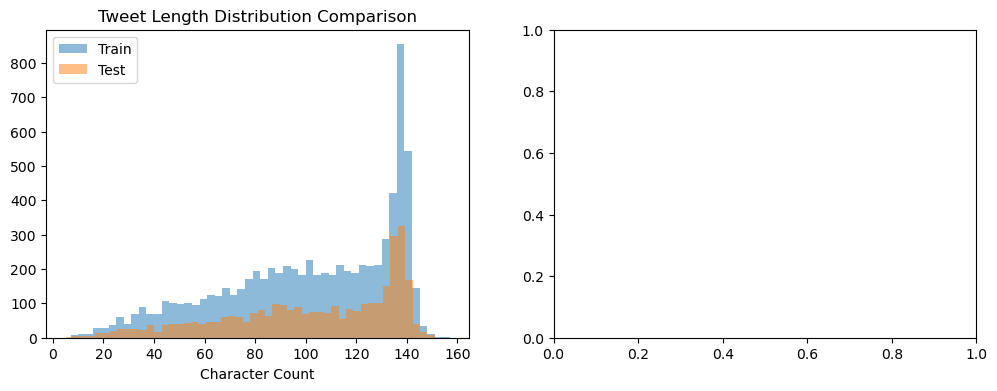

In [ ]:
# Add word_count columns if missing
df_train["word_count"] = df_train["text"].str.split().str.len()
df_test["word_count"] = df_test["text"].str.split().str.len()

# Compare text length distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_train['length'], bins=50, alpha=0.5, label='Train')
plt.hist(df_test['length'], bins=50, alpha=0.5, label='Test')
plt.title('Tweet Length Distribution Comparison')
plt.xlabel('Character Count')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df_train['word_count'], bins=50, alpha=0.5, label='Train')
plt.hist(df_test['word_count'], bins=50, alpha=0.5, label='Test')
plt.title('Word Count Distribution Comparison')
plt.xlabel('Word Count')
plt.legend()

plt.tight_layout()
plt.show()

# Compare keyword coverage
train_keywords = set(df_train['keyword'].dropna())
test_keywords = set(df_test['keyword'].dropna())

print("\nKeyword Coverage Analysis:")
print(f"Unique keywords in training set: {len(train_keywords)}")
print(f"Unique keywords in test set: {len(test_keywords)}")
print(f"Keywords in test but not in train: {len(test_keywords - train_keywords)}")
print(f"Percentage of test keywords covered by training: {(len(test_keywords.intersection(train_keywords)) / len(test_keywords)) * 100:.2f}%")

# Data Preprocessing and Model Setup

### Hyperparameters
- **BATCH_SIZE = 32**: Standard batch size for transformer models
- **VAL_SPLIT = 0.2**: 80% training, 20% validation split
- **MAX_LENGTH = 160**: Maximum tweet length (in tokens)
- **MODEL_NAME = "distilbert-base-uncased"**: Pre-trained model we'll fine-tune

### Data Processing Pipeline
1. Split data into train/validation sets
2. Convert to HuggingFace Datasets format
3. Tokenize text using DistilBERT tokenizer
4. Create PyTorch DataLoaders

The tokenization process converts text into numbers that the model can understand:
- Splits text into tokens (subwords)
- Adds special tokens ([CLS], [SEP])
- Pads sequences to same length
- Creates attention masks

In [7]:
# 1. Basic Dataset Statistics

# Class distribution in training set
print("Training Set Class Distribution:")
print(df_train["target"].value_counts(normalize=True))

# Missing values analysis
print("\nMissing Values in Training Set:")
print(df_train.isnull().sum())
print("\nMissing Values in Test Set:")
print(df_test.isnull().sum())

# Text statistics
df_train["word_count"] = df_train["text"].str.split().str.len()
df_test["word_count"] = df_test["text"].str.split().str.len()

print("\nText Statistics (Training Set):")
print(df_train[["length", "word_count"]].describe())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df_train["length"], bins=50)
plt.title("Distribution of Tweet Lengths (Training)")
plt.xlabel("Character Count")

plt.subplot(1, 2, 2)
plt.hist(df_train["word_count"], bins=50)
plt.title("Distribution of Word Counts (Training)")
plt.xlabel("Word Count")
plt.tight_layout()
plt.show()BATCH_SIZE = 32
VAL_SPLIT  = 0.2
MAX_LENGTH = 160
MODEL_NAME = "distilbert-base-uncased"

In [8]:
from sklearn.model_selection import train_test_split

# stratified split
train_df, val_df = train_test_split(
    df_train,
    test_size=VAL_SPLIT,
    random_state=42,
    stratify=df_train["target"],
)

# Model Training

### Training Configuration
- **Model**: DistilBERT with binary classification head
- **Loss**: CrossEntropyLoss (standard for classification)
- **Optimizer**: AdamW with learning rate 1e-5
- **Epochs**: 2 full passes through the training data

### Training Process
For each epoch, we:
1. Set model to training mode
2. Process mini-batches of data
3. Compute loss and gradients
4. Update model parameters
5. Track and display average loss

### What to Watch For
- Decreasing loss values indicate learning
- Too rapid decrease might suggest overfitting
- Stable loss suggests good learning rate

The training loop includes proper handling of:
- GPU acceleration (if available)
- Gradient computation and updates
- Batch processing
- Loss tracking


In [9]:
# wrap pandas DataFrames in HF Dataset
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(df_test)

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )

# apply tokenization
train_ds = train_ds.map(tokenize_batch, batched=True)
val_ds   = val_ds.map(tokenize_batch, batched=True)
test_ds  = test_ds.map(tokenize_batch, batched=True)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [10]:
print("Train columns:", train_ds.column_names)
print("Train columns:", val_ds.column_names)
print("Train columns:", test_ds.column_names)

Train columns: ['id', 'keyword', 'location', 'text', 'target', 'length', '__index_level_0__', 'input_ids', 'attention_mask']
Train columns: ['id', 'keyword', 'location', 'text', 'target', 'length', '__index_level_0__', 'input_ids', 'attention_mask']
Train columns: ['id', 'keyword', 'location', 'text', 'length', 'input_ids', 'attention_mask']


# Rename, Format & Build DataLoaders


In [11]:
# Columns we’d like to drop
drop_cols = ["__index_level_0__", "length"]

# Remove from train & val
train_ds = train_ds.remove_columns([c for c in drop_cols if c in train_ds.column_names])
val_ds   = val_ds.remove_columns(  [c for c in drop_cols if c in val_ds.column_names])
test_ds  = test_ds.remove_columns( [c for c in drop_cols if c in test_ds.column_names])

# Rename 'target' → 'labels' (only train/val have it)
if "target" in train_ds.column_names:
    train_ds = train_ds.rename_column("target", "labels")
if "target" in val_ds.column_names:
    val_ds   = val_ds.rename_column("target", "labels")

In [12]:
def convert_to_torch_features(batch):
    return {
        'input_ids': torch.tensor(batch['input_ids']),
        'attention_mask': torch.tensor(batch['attention_mask']),
        'labels': torch.tensor(batch['labels']) if 'labels' in batch else None
    }

In [13]:
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DataLoader
import torch

# Convert features to PyTorch format and select only the columns we need
train_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_ds.set_format('torch', columns=['input_ids', 'attention_mask'])

# Simple collate function
def collate_fn(examples):
    input_ids = torch.stack([x['input_ids'] for x in examples])
    attention_mask = torch.stack([x['attention_mask'] for x in examples])
    if 'labels' in examples[0]:
        labels = torch.tensor([x['labels'] for x in examples])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}
    return {'input_ids': input_ids, 'attention_mask': attention_mask}

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Temporarily disable multiprocessing
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

# Steps per Epoch (optional)

In [14]:
steps_per_epoch = len(train_loader)
print("Batches per epoch:", steps_per_epoch)

Batches per epoch: 191


# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [15]:
MODEL_NAME = "distilbert-base-uncased"

# 1) Tokenizer (handles tokenization + attention mask)
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

# 2) Pretrained classifier head on top of DistilBERT
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,            # your binary task
)

# 3) Try to use DirectML for AMD GPU, fallback to CPU if not available
try:
    import torch_directml
    dml = torch_directml.device()
    print(f"Using DirectML device: {dml}")
    device = dml
except Exception:
    device = torch.device("cpu")
    print(f"Falling back to CPU: {device}")
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using DirectML device: privateuseone:0


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# Setup optimizer & loss

In [16]:
from torch.optim import AdamW

# Binary classification → use CrossEntropyLoss (expects raw logits)
criterion = torch.nn.CrossEntropyLoss()

# AdamW is standard for Transformers, but disable foreach for DirectML compatibility
optimizer = optim.AdamW(
    model.parameters(), 
    lr=1e-5,
    foreach=False  # Disable foreach path to avoid CPU fallback
)

# Fine-tune DistilBERT

In [ ]:
EPOCHS = 2

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}/{EPOCHS} — loss: {avg_loss:.4f}")

c:\Users\samin\miniconda3\envs\nlp-env\lib\site-packages\torch\optim\adamw.py:380: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  exp_avg.lerp_(grad, 1 - beta1)


# Model Evaluation

### Evaluation Metrics
We use several metrics to assess model performance:

1. **Confusion Matrix**
   - Shows True Positives, False Positives, True Negatives, False Negatives
   - Helps visualize where model makes mistakes

2. **F1 Score**
   - Harmonic mean of precision and recall
   - Balances false positives and false negatives
   - Particularly important for imbalanced datasets

### Prediction Process
The `get_predictions` function:
1. Sets model to evaluation mode
2. Disables gradient computation
3. Processes batches of data
4. Returns both true labels and predicted probabilities

### Visualization
The confusion matrix plot shows:
- Correct predictions on diagonal
- Errors off-diagonal
- Color intensity indicates frequency
- Labels for easy interpretation

In [ ]:
def get_predictions(loader):
    """Run model over a DataLoader and return (y_true, y_pred_probs)."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            # Move tensors to DirectML device individually
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.softmax(logits, dim=-1)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return (
        np.concatenate(all_labels, axis=0),
        np.concatenate(all_preds,  axis=0),
    )

def display_confusion_matrix(y_true, y_pred_probs, dataset_name):
    y_pred = np.argmax(y_pred_probs, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Not Disaster","Disaster"],
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix — {dataset_name}")
    plt.show()
    # Compute a simple F1:
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    f1 = tp / (tp + (fp+fn)/2)
    print(f"{dataset_name} F1 score: {f1:.2f}\n")

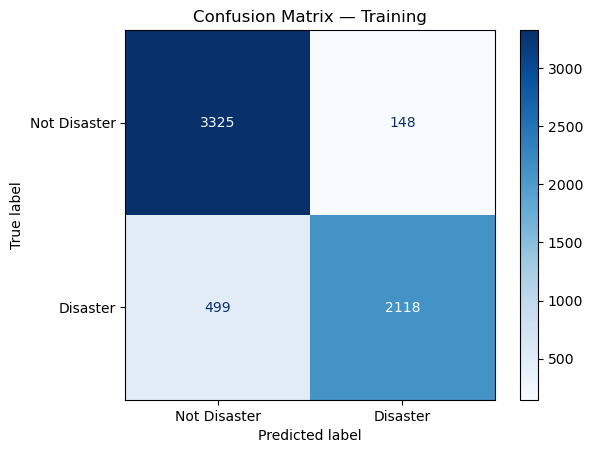

Training F1 score: 0.87



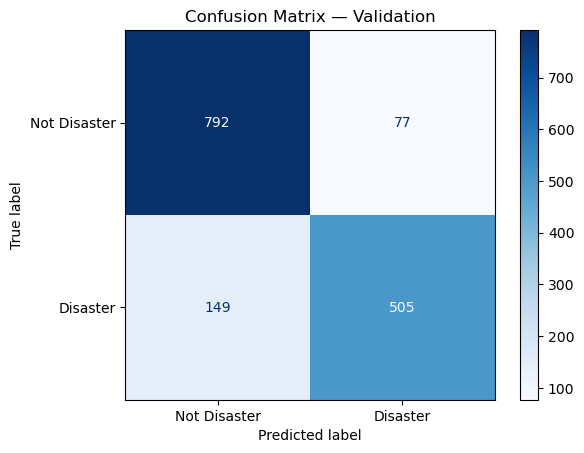

Validation F1 score: 0.82



In [19]:
# Cell: Evaluate
y_train, p_train = get_predictions(train_loader)
display_confusion_matrix(y_train, p_train, "Training")

y_val, p_val = get_predictions(val_loader)
display_confusion_matrix(y_val, p_val, "Validation")